##### Neural Net with Multiple Neurons

Now let's take one step towards further complexity by increasing the size of our hidden layer. Before, we had only one neuron; let's add a second, and then generalize the architecture so that the *width* of the net (the number of neurons) can be flexibly specified. 

Along the way, let's make a few other changes from before. Most importantly, this time we will create data that has some degree of nonlinearity, and we will see if the NN provides an improvement on the OLS results. We will also make our architecture a bit more flexible.

First, let's go ahead and generate some data, similar to before but with a nonlinearity included. This time, we will make it so that $Y \in (0,1)$ from the start, and save ourselves from having to do any normalization.

In [375]:
# Bring in necessary packages
import numpy as np
from scipy.stats import norm

# Set seed
np.random.seed(3172024)
datasize=10000

# Generate the U variable uniformly distributed between 0 and 2
U = np.random.uniform(0, 2, (datasize, 1))

# Generate the categorical variable
B = np.random.choice([0, 1], size=(datasize, 1), p=[0.7, 0.3])

# Draw an error
e = norm.rvs(size=(datasize,1), scale = .005)

# set an intercept b0 and slopes b1 and b2
b0 = 0.2
b1= .05
b2 = .005
b3 = 0.2
b4 = 1
b5 = 0.5
truecoef = [b0, b1, b2]

# Generate our Y variable
Y = b0 + b1*U + b2*B - b3*U**(1/2) + b5*np.abs(np.cos(b4*U)) + e
# Y = b0 + b1*U + b2*B + b3*U**(1/3) + e
data = np.concatenate((U, B, Y), axis=1)

# print the min and max of Y
print("the min of Y is", np.min(Y), "and the max of Y is", np.max(Y))


the min of Y is 0.017499568157597286 and the max of Y is 0.7047285931497049


Plot the data with $U$ on the X-axis and $Y$ on the Y-axis. 

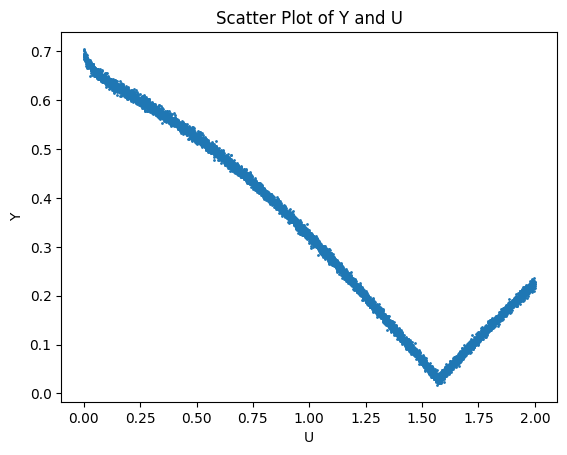

In [376]:
# graph our data
import matplotlib.pyplot as plt

# Sort the U and Y values by U
sorted_indices = np.argsort(U.flatten())
sorted_U = U[sorted_indices]
sorted_Y = Y[sorted_indices]

# Create the line plot
plt.scatter(sorted_U, sorted_Y, s=1)
plt.xlabel('U')
plt.ylabel('Y')
plt.title('Scatter Plot of Y and U')
plt.show()

We go ahead and split into training and validation sets:

In [377]:
# size of training set:
train_size = round(0.8 * data.shape[0])

# size of validation set:
val_size   = data.shape[0] - train_size

# Get indices for the training set
indices = np.random.choice(range(data.shape[0]), size=train_size, replace=False)
valindices = np.setdiff1d(np.arange(data.shape[0]), indices)

# Use these indices to create the training set
train_data = data[indices,:]

# Use the remaining indices for the validation set
val_data = data[valindices,:]

Now, let's go get our OLS coefficients to compare against. Note that stats model has a command to add a constant that we can take advantage of for the regression.

In [378]:
# bring in package for OLS
import statsmodels.api as sm

# X variables:
X = train_data[:,0:2]
# Y variable:
Y = train_data[:,2].reshape(-1, 1)

# Run regression with a constant term added
OLS = sm.OLS(Y, sm.add_constant(X))
# OLS = sm.OLS(Y, X)
resultsOLS = OLS.fit()

# save these coefficients:
OLScoef = resultsOLS.params

print("The OLS coefficients are ", OLScoef, "compared to the true values of ", truecoef)

The OLS coefficients are  [ 0.66224068 -0.32909361  0.00526712] compared to the true values of  [0.2, 0.05, 0.005]


By design, the OLS regression now struggles to recover the true parameters. The treatment effect of $B$ is well estimated but the intercept appears biased upwards and the coefficient for U biased downwards. This is thanks to the nonlinear $U$ term which we included.

Now let's try and estimate the model using a neural net. Last time, we had a hidden layer with just one neuron. We know this is equivalent to estimating $Y$ as:

$$
\hat{Y_i} = \sigma(\textbf{w} \cdot x_i)
$$

Where the only parameters to set were the weights $w$, which solve:

$$
\text{min}_w \sum_{i=1}^{N} \dfrac{(\hat{y}_i - y_i)^2}{2} = \text{min}_w L
$$

Now we can add a second cell, which is a second sigmoid function taking a different dot product of $X$. We then add these two values together with their own weights $\alpha$. So we are now predicting $Y$ as:

$$
\hat{Y_i} = \alpha_1 \sigma( \textbf{w}_1 \cdot x_i) + \alpha_2 \sigma( \textbf{w}_2 \cdot x_i)
$$

Where we now find the weight matrix $\textbf{w}$ and the vector $\bf{\alpha}$ to solve the same minimization problem. $\textbf{w}$ has rows equal to the number of variables in our $X$ data and columns equal to the width of the net, $\omega$ (number of neurons); $\bf{\alpha}$ is a vector of length $\omega$. So $w_{k,j}$ is the scalar multiplied by the $k^{\text{th}}$ column of $X$ in neuron $j$, and $\textbf{w}_j$ denotes the weight vector of the $j^{\text{th}}$ neuron.

It may seem weird to be adding two separate sigmoids together, but this will allow us to more flexibly capture different features of the data. Imagine that our DGP consisted of two nonlinear functions:

$$
f(x) = g(x) + l(x)
$$

Above, we were using one sigmoid to approximate the sum of these two functions, while we now allow the network to model them separately.

We are also going to add in a *bias* to the network. This will be a vector $\textbf{b} = b_1, \dots, b_{\omega}$ of constants added inside each activation function, so our 2 neuron neural net becomes:

$$
\hat{Y_i} = \alpha_1 \sigma(b_1 + \textbf{w}_1 \cdot x_i) + \alpha_2 \sigma(b_2 + \textbf{w}_2 \cdot x_i)
$$

It is easy to show that this is equivalent to adding a single constant $b^{*}$:

$$
\hat{Y_i} = b^{*} + \alpha_1 \sigma(\textbf{w}_1 \cdot x_i) + \alpha_2 \sigma(\textbf{w}_2 \cdot x_i)
$$

Because the net can always set the $w_i$ vector entirely to 0 for some neuron $i$, in which case that neuron becomes $\alpha_i \sigma(b_i)$ which is just a constant. In practice, we add in these neuron-specific constants by adding on a constant to our data. Let's do this internal to our net. 

The derivative of our loss function $L$ wrt our inner weights $\textbf{w}$ is unchanged:

$$
\dfrac{\partial L}{\partial w_{k,j}} = \sum_{i=1}^{N} e_i * x_{k,i} * \sigma^{\prime}(\textbf{w}_{j} x_i)
$$

Where $x_{k,i}$ is the value of the $k^{\text{th}}$ variable for the $i^{\text{th}}$ data point. And the derivative of $L$ wrt the outer weights $\bf{\alpha}$ is:

$$
\dfrac{\partial L}{\partial \alpha_j} = \sum_{i=1}^{N} e_i * \sigma(\textbf{w}_j x_i)
$$

We will also take a few other steps:
1. To avoid overflow in the sigmoid function, clip values of $x$ at some large number; we use -500 and 500
2. Let's decrease the learning rate as we go along; every 100 epochs, we decrease the rate by dividing by 1.2
3. Track the history of the mean absolute error
4. Make the learning rate and number of epochs an argument when the net is instantiated

In [383]:
# create a neural network class
class NeuralNetwork1:
    # Initialize variables
    def __init__(self, X, Y, learning_rate, epochs):
        np.random.seed(3172024)
        # self.input      = X
        self.input = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)  # Add a constant term to input
        self.output     = Y
        # initialize weights for one hidden layer
        self.weights1    = np.random.randn(self.input.shape[1], 2) * np.sqrt(1 / self.input.shape[1])
        # self.weights1    = np.random.rand(self.input.shape[1],2) 
        # print(self.weights1)
        # self.weights2    = np.random.rand(2,1)
        self.weights2 = np.random.randn(2, 1) * np.sqrt(1 / 2)
        self.learning_rate = learning_rate
        self.epochs        = epochs
        self.error_history = []

    # Activation function
    # let's use sigmoid, with the derivative built in
    def sigmoid(self, x, derivative=False):
        x = np.clip(x, -500, 500)  # Clip values to prevent overflow
        sig = 1 / (1 + np.exp(-x))
        if derivative:
            return sig*(1-sig)
        return sig
    
    # data move through the network: take the dot product of inputs and weights, then feed it into the sigmoid function
    def feed_forward(self):
        # calculate value at each neuron
        self.neuron1    = self.sigmoid(np.dot(self.input, self.weights1[:,0]))
        self.neuron2    = self.sigmoid(np.dot(self.input, self.weights1[:,1]))

        # calculate the weighted sum of the neurons
        self.hidden     = self.weights2[0,0]*self.neuron1 + self.weights2[1,0]*self.neuron2
        self.hidden     = self.hidden.reshape(-1,1)

    # then go backwards through the network to update weights
    def backpropagation(self):
        # error between prediction and actual
        self.error  = self.output - self.hidden

        # adjustment factor for the outer weights
        delta_outer = self.error

        # adjustment factor for inner weights
        delta_inner1 = self.error * self.sigmoid(np.dot(self.input, self.weights1[:,0]), derivative=True).reshape(-1,1) * self.weights2[0,0]
        delta_inner2 = self.error * self.sigmoid(np.dot(self.input, self.weights1[:,1]), derivative=True).reshape(-1,1) * self.weights2[1,0]

        # adjust the inner weights
        self.weights1[:,0] += self.learning_rate*np.dot(self.input.T, delta_inner1).squeeze()
        self.weights1[:,1] += self.learning_rate*np.dot(self.input.T, delta_inner2).squeeze()

        # update outer weights
        self.weights2[0,0] += self.learning_rate*np.dot(self.neuron1.T, delta_outer)
        self.weights2[1,0] += self.learning_rate*np.dot(self.neuron2.T, delta_outer)
        
    # define a training function:
    def train(self):
        self.error_history.clear()
        for epoch in range(self.epochs):
            if epoch % 500 == 0 and epoch != 0:
                self.learning_rate /= 1.2

            # flow forward and produce an output
            self.feed_forward()

            # go back though the network to make corrections based on the output -- eg gradient descent
            self.backpropagation()    

            # We can track our improvement across epochs:
            self.error_history.append(np.average(np.abs(self.error)))
    
    # function to predict output                               
    def predict(self, new_input):
        input_const = np.concatenate((new_input, np.ones((new_input.shape[0], 1))), axis=1)
        # input_const = new_input
        prediction = self.weights2[0,0] * self.sigmoid(np.dot(input_const, self.weights1[:,0])) + self.weights2[1,0] * self.sigmoid(np.dot(input_const, self.weights1[:,1]))
        return prediction

Now let's instantiate the net, train it, and take advantage of the error history functionality to plot the error at each epoch.

The lowest error was 0.03931 at epoch: 338


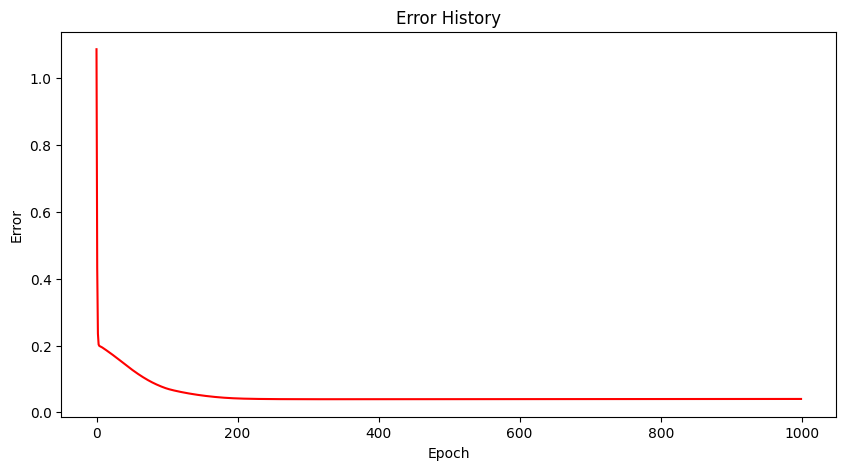

In [384]:
# train the more flexible NN   
NN1 = NeuralNetwork1(X, Y.reshape(-1,1),0.0001,1000)

# train neural network
NN1.train()

# Find the epoch with the lowest error
min_error_epoch = np.argmin(NN1.error_history)
min_error = np.min(NN1.error_history)
print(f"The lowest error was {np.round(min_error,5)} at epoch: {min_error_epoch}")

# then plot the errors:
plt.figure(figsize=(10,5))
plt.plot(NN1.error_history,'r')
plt.title('Error History')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

Now we will plot the fit of the neural network vs. OLS on our validation data.

The OLS MSE is 0.00431 the NN SSE is 0.00292
The OLS SSE is 8.63 the NN SSE is 5.84


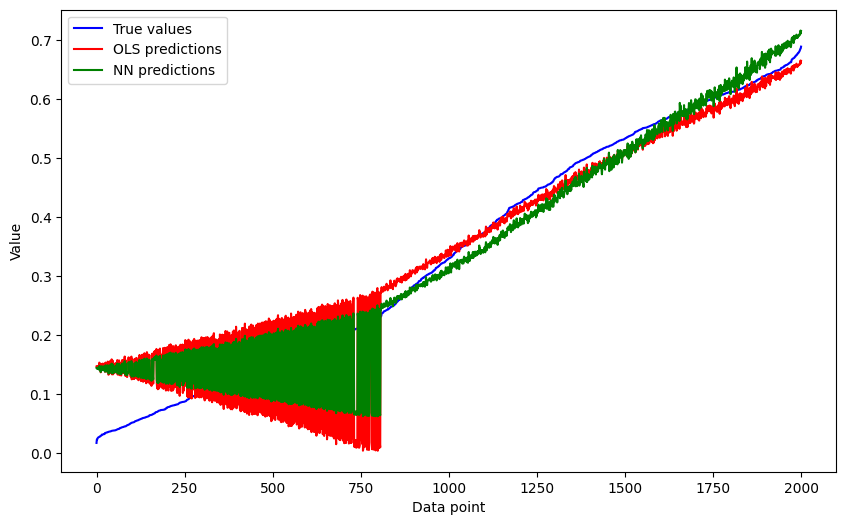

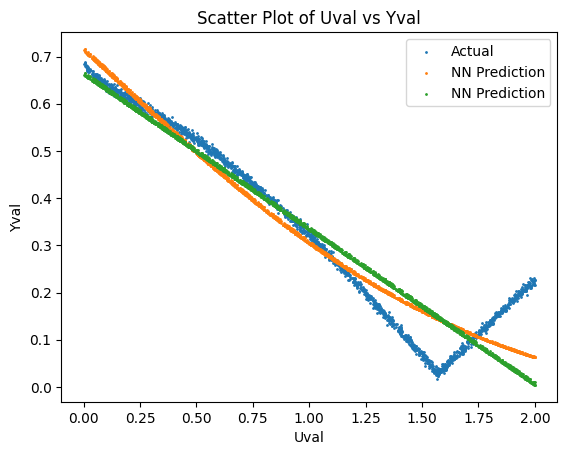

In [402]:
import pandas as pd

# calculate predictions from both models
NNpred1  = NN1.predict(val_data[:,0:2])
OLSpred = OLScoef[0] + np.dot(val_data[:,0:2], OLScoef[1:3])

# calculate errors
OLSerror = OLSpred - val_data[:,2].squeeze()
NNerror1  = NNpred1 - val_data[:,2].squeeze()

# sum of squared errors
OLSSSE = np.sum(OLSerror**2)
NNSSE1 = np.sum(NNerror1**2)

# mean squared error
ols_mse = np.mean(OLSerror**2)
nn_mse1 = np.mean(NNerror1**2)

# now let's plot
data = pd.DataFrame({
    'Uval': val_data[:,0].squeeze(),
    'Yval': val_data[:,2].squeeze(),
    'OLSpred': OLSpred.squeeze(),
    'NNpred': NNpred1.squeeze()
})

print("The OLS MSE is", np.round(ols_mse,5), "the NN SSE is", np.round(nn_mse1,5))
print("The OLS SSE is", np.round(OLSSSE,2), "the NN SSE is", np.round(NNSSE1,2))

# Sort the data by Y_scaled
data.sort_values('Yval', inplace=True)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['Yval'].values, 'b', label='True values')
plt.plot(data['OLSpred'].values, 'r', label='OLS predictions')
plt.plot(data['NNpred'].values, 'g', label='NN predictions')
plt.legend()
plt.xlabel('Data point')
plt.ylabel('Value')
plt.show()

# Scatter plot of Uval vs Yval
plt.scatter(data['Uval'], data['Yval'], label='Actual', s=1)
# Scatter plot of Uval vs NNpred
plt.scatter(data['Uval'], data['NNpred'], label='NN Prediction', s=1)
plt.scatter(data['Uval'], data['OLSpred'], label='NN Prediction', s=1)
# Set labels and title
plt.xlabel('Uval')
plt.ylabel('Yval')
plt.title('Scatter Plot of Uval vs Yval')
# Add legend
plt.legend()
# Show the plot
plt.show()

We do now get some substantial improvement over the OLS -- though of course we designed our problem this way But the fit can still hardly be characterized as close.

Now, to make our function more flexible we may want to include an activation function in our output layer also. While we're at it, we can weight the portion from the data and add in a constant.

$$
\hat{Y_i} = b_0 + b_1 * \sigma( \alpha_1 \sigma( \textbf{w}_1 \cdot x_i) + \alpha_2 \sigma( \textbf{w}_2 \cdot x_i))
$$

This of course changes our derivatives. First let's define the summation of the hidden layer:

$$
\chi \equiv \alpha_1 \sigma( \textbf{w}_1 \cdot x_i) + \alpha_2 \sigma( \textbf{w}_2 \cdot x_i)
$$

And we can then see the derivates are:

$$
\dfrac{\partial L}{\partial b_0} =  \sum_1^N \hat{e}_i
$$

$$
\dfrac{\partial L}{\partial b_1} = \sum_1^N \hat{e}_i \sigma( \chi)
$$

$$
\dfrac{\partial L}{\partial \alpha_j} = \sum_1^N \hat{e}_i b_1 \sigma^{\prime}(\chi) \sigma(\textbf{w}_j x_i)
$$

$$
\dfrac{\partial L}{\partial w_{j }} = \sum_1^N \hat{e}_i b_1 \sigma^{\prime}(\chi) \sigma(\textbf{w}_j x_i)
$$

In [397]:
# create a neural network class
class NeuralNetwork2:
    # Initialize variables
    def __init__(self, X, Y, learning_rate, epochs):
        np.random.seed(3172024)
        self.input = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)  # Add a constant term to input
        self.output     = Y

        # initialize weights for one hidden layer
        self.weights1    = np.random.randn(self.input.shape[1], 2) * np.sqrt(1 / self.input.shape[1])
        self.weights2 = np.random.randn(2, 1) * np.sqrt(1 / 2)
        self.learning_rate = learning_rate
        self.epochs        = epochs
        self.error_history = []
        self.weights3 = np.random.randn(2, 1) * np.sqrt(1 / 2)

    # Activation function
    # let's use sigmoid, with the derivative built in
    def sigmoid(self, x, derivative=False):
        x = np.clip(x, -500, 500)  # Clip values to prevent overflow
        sig = 1 / (1 + np.exp(-x))
        if derivative:
            return sig*(1-sig)
        return sig
    
    # data move through the network: take the dot product of inputs and weights, then feed it into the sigmoid function
    def feed_forward(self):
        # calculate neurons
        self.neuron1 = self.sigmoid(np.dot(self.input, self.weights1[:,0]))
        self.neuron2 = self.sigmoid(np.dot(self.input, self.weights1[:,1]))
        self.chi = self.weights2[0,0]*self.neuron1 + self.weights2[1,0]*self.neuron2
        self.chi = self.chi.reshape(-1,1)

        # Now calculate our prediction
        self.hidden  = self.weights3[0,0] + self.weights3[1,0]*self.sigmoid(self.chi)
        self.hidden = self.hidden.reshape(-1,1)

    # then go backwards through the network to update weights
    def backpropagation(self):
        # error between prediction and actual
        self.error  = self.output - self.hidden
        # first update the weights in the output layer
        # delta_outer = self.error * self.hidden
        delta_outer = self.error * self.sigmoid(self.chi, derivative=True)

        # update innerweights
        delta_inner1 = self.error * self.sigmoid(self.chi, derivative=True) * self.sigmoid(np.dot(self.input, self.weights1[:,0]), derivative=True).reshape(-1,1) * self.weights2[0,0]
        delta_inner2 = self.error * self.sigmoid(self.chi, derivative=True) * self.sigmoid(np.dot(self.input, self.weights1[:,1]), derivative=True).reshape(-1,1) * self.weights2[1,0]

        self.weights1[:,0] += self.learning_rate*np.dot(self.input.T, delta_inner1).squeeze()
        self.weights1[:,1] += self.learning_rate*np.dot(self.input.T, delta_inner2).squeeze()

        # update outer weights
        self.weights2[0,0] += self.learning_rate*np.dot(self.neuron1.T, delta_outer)
        self.weights2[1,0] += self.learning_rate*np.dot(self.neuron2.T, delta_outer)

        # update intercept
        self.weights3[0,0] += self.learning_rate*np.sum(self.error)
        self.weights3[1,0] += self.learning_rate*np.dot(self.error.flatten(), self.sigmoid(self.chi)).squeeze()

    # define a training function:
    def train(self):
        self.error_history.clear()
        for epoch in range(self.epochs):
            if epoch % 500 == 0 and epoch != 0:
                self.learning_rate /= 1.2
        
            # flow forward and produce an output
            self.feed_forward()
            # go back though the network to make corrections based on the output -- eg gradient descent
            self.backpropagation()    
            # We can track our improvement across epochs:
            self.error_history.append(np.average(np.abs(self.error)))
        # print(self.weights2)
    
    # function to predict output                               
    def predict(self, new_input):
        input_const = np.concatenate((new_input, np.ones((new_input.shape[0], 1))), axis=1)
        prediction = self.weights3[0,0]  + self.weights3[1,0] * self.sigmoid(self.weights2[0,0] * self.sigmoid(np.dot(input_const, self.weights1[:,0])) + self.weights2[1,0] * self.sigmoid(np.dot(input_const, self.weights1[:,1])))
        return prediction

Let's train and check the fit:

The lowest error was 0.03724 at epoch: 999


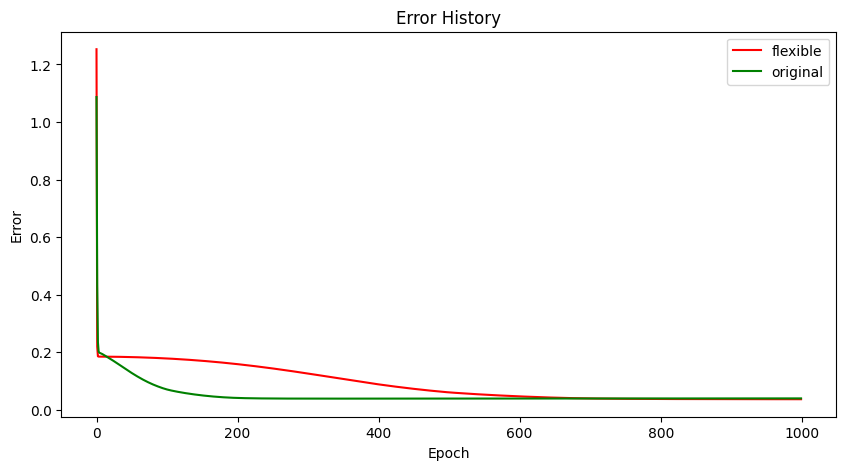

The OLS MSE is 0.00431 the new NN SSE is 0.00245 the old NN SSE is 0.00292
The OLS SSE is 8.63 the new NN SSE is 4.9 the old NN SSE is 5.84


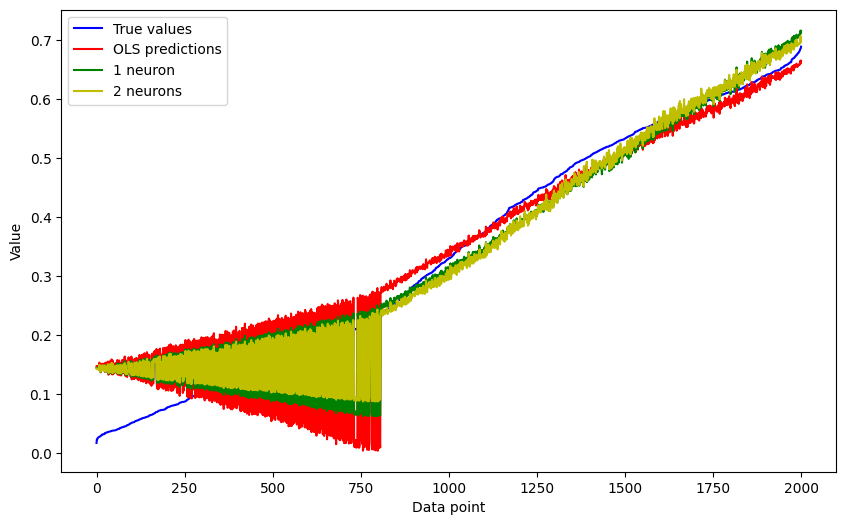

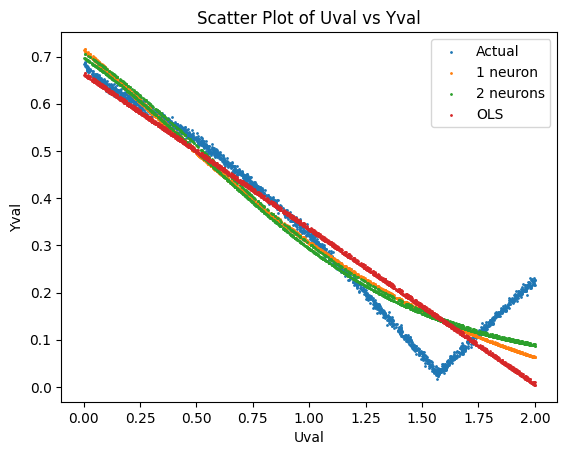

In [406]:
# train the more flexible NN   
NN2 = NeuralNetwork2(X, Y.reshape(-1,1),0.0001,1000)

# train neural network
NN2.train()

# Find the epoch with the lowest error
min_error_epoch = np.argmin(NN2.error_history)
min_error = np.min(NN2.error_history)
print(f"The lowest error was {np.round(min_error,5)} at epoch: {min_error_epoch}")

# then plot the errors:
plt.figure(figsize=(10,5))
plt.plot(NN2.error_history,'r', label='flexible')
plt.plot(NN1.error_history,'g', label='original')
plt.legend()
plt.title('Error History')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

# calculate predictions from both models
NNpred2  = NN2.predict(val_data[:,0:2])

# calculate errors
NNerror2  = NNpred2 - val_data[:,2].squeeze()

# sum of squared errors
NNSSE2 = np.sum(NNerror2**2)

# mean squared error
nn_mse2 = np.mean(NNerror2**2)

# now let's plot
data = pd.DataFrame({
    'Uval': val_data[:,0].squeeze(),
    'Yval': val_data[:,2].squeeze(),
    'OLSpred': OLSpred.squeeze(),
    'NNpred1': NNpred1.squeeze(),
    'NNpred2': NNpred2.squeeze()
})

print("The OLS MSE is", np.round(ols_mse,5), "the new NN SSE is", np.round(nn_mse2,5), "the old NN SSE is", np.round(nn_mse1,5))
print("The OLS SSE is", np.round(OLSSSE,2), "the new NN SSE is", np.round(NNSSE2,2), "the old NN SSE is", np.round(NNSSE1,2))

# Sort the data by Y_scaled
data.sort_values('Yval', inplace=True)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['Yval'].values, 'b', label='True values')
plt.plot(data['OLSpred'].values, 'r', label='OLS predictions')
plt.plot(data['NNpred1'].values, 'g', label='1 neuron')
plt.plot(data['NNpred2'].values, 'y', label='2 neurons')
plt.legend()
plt.xlabel('Data point')
plt.ylabel('Value')
plt.show()

# Scatter plot of Uval vs Yval
plt.scatter(data['Uval'], data['Yval'], label='Actual', s=1)
# Scatter plot of Uval vs NNpred
plt.scatter(data['Uval'], data['NNpred1'], label='1 neuron', s=1)
plt.scatter(data['Uval'], data['NNpred2'], label='2 neurons', s=1)
plt.scatter(data['Uval'], data['OLSpred'], label='OLS', s=1)
# Set labels and title
plt.xlabel('Uval')
plt.ylabel('Yval')
plt.title('Scatter Plot of Uval vs Yval')
# Add legend
plt.legend()
# Show the plot
plt.show()

Adding in a bit more flexibility with an activation function on our output did increase our fit bit a bit, though not dramatically so.

Let's do two final things to improve our net. First, let's generalize the architecture so that we can specify the number of neurons as a hyperparameter and flexibly increase and decrease the width. Second, let's take advantage of our training and validation data to stop training at a smart point, when the out-of-sample fit becomes consistently worse. This is important when increasing the flexibility of the model, since a more flexible model is also more prone to overfitting the data.

In [468]:
# create a neural network class
class NeuralNetwork_FlexibleWidth:
    # Initialize variables
    def __init__(self, X, Y, Xval, Yval, learning_rate, epochs, width):
        np.random.seed(3172024)
        self.input = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)  # Add a constant term to input
        self.output     = Y
        self.width      = width
        self.X_val = np.concatenate((Xval, np.ones((Xval.shape[0], 1))), axis=1)  # Add a constant term to input
        self.Y_val = Yval
        # initialize weights for one hidden layer
        self.weights1    = np.random.randn(self.input.shape[1],self.width) * np.sqrt(1 / self.input.shape[1])
        # print(self.weights1)
        self.weights2    = np.random.randn(self.width,1) * np.sqrt(1 / width)
        self.error_history = []
        self.error_history_oos = []
        self.learning_rate = learning_rate
        self.epochs        = epochs
        self.weights3 = np.random.randn(2, 1) * np.sqrt(1 / width)
        self.last_val_rmse = float('inf')

    # Activation function
    # let's use sigmoid, with the derivative built in
    def sigmoid(self, x, derivative=False, derivative2=False):
        x = np.clip(x, -500, 500)  # Clip values to prevent overflow
        if derivative:
            return (1 / (1 + np.exp(-x)))*(1- (1 / (1 + np.exp(-x))))
        if derivative2:
            return ((1 / (1 + np.exp(-x)))*(1- (1 / (1 + np.exp(-x))))) * (1 - 2 * 1 / (1 + np.exp(-x)))
        return 1 / (1 + np.exp(-x))
    
    # data move through the network: take the dot product of inputs and weights, then feed it into the sigmoid function
    def feed_forward(self):
        self.neurons = np.array([self.sigmoid(np.dot(self.input, self.weights1[:, i])) for i in range(self.width)])
        self.chi = np.dot(np.array(self.neurons).T, self.weights2)
        self.chi = self.chi.reshape(-1, 1)
        self.hidden = self.weights3[0, 0] + np.dot(self.sigmoid(self.chi), self.weights3[1, 0])

    def validation_error(self):
        self.neuronshat = np.array([self.sigmoid(np.dot(self.X_val, self.weights1[:, i])) for i in range(self.width)])
        self.chihat = np.dot(np.array(self.neuronshat).T, self.weights2)
        self.chihat = self.chihat.reshape(-1, 1)
        self.yhat = self.weights3[0, 0] + np.dot(self.sigmoid(self.chihat), self.weights3[1, 0])
        self.val_rmse = np.average(np.abs(self.Y_val - self.yhat))

    # then go backwards through the network to update weights
    def backpropagation(self):
        # error between prediction and actual
        self.error  = self.output - self.hidden.reshape(-1,1)

        # first update the weights in the output layer
        delta_outer = self.error * self.sigmoid(self.chi, derivative=True)

        # calculate step for inner weights
        delta_inners = [
            self.error * self.sigmoid(self.chi, derivative=True) * self.sigmoid(np.dot(self.input, self.weights1[:, i]), derivative=True).reshape(-1, 1) * self.weights2[i, 0]
            for i in range(self.width)
        ]
        # update inner weights
        for i in range(self.width):
            self.weights1[:, i] += self.learning_rate * np.dot(self.input.T, delta_inners[i].squeeze()).squeeze()
            self.weights2[i, 0] += self.learning_rate * np.dot(np.array(self.sigmoid(np.dot(self.input, self.weights1[:, i]), derivative=False)).T, delta_outer)

        # update outer weights
        # self.weights2 += self.learning_rate * np.dot(np.array([self.sigmoid(np.dot(self.input, self.weights1[:, i]), derivative=False) for i in range(self.width)]).T, delta_outer)
        self.weights3[0, 0] += self.learning_rate * np.sum(self.error)
        self.weights3[1, 0] += self.learning_rate * np.dot(self.error.flatten(), self.sigmoid(self.chi)).squeeze()


    # define a training function:
    def train(self):
        self.error_history.clear()
        val_error_periods = 0

        for epoch in range(self.epochs):
            if epoch % 500 == 0 and epoch != 0:
                self.learning_rate /= 1.2
            # flow forward and produce an output
            self.feed_forward()

            # calculate the out of sample error            
            self.validation_error()
            if self.val_rmse > self.last_val_rmse*1.001:
                val_error_periods += 1

            if val_error_periods > 20:
                break

            # go back though the network to make corrections based on the output -- eg gradient descent
            self.backpropagation()    
            # We can track our improvement across epochs:
            self.error_history.append(np.average(np.abs(self.error)))
            self.error_history_oos.append(self.val_rmse)

        # print(self.weights2)
    
    # function to predict output                               
    def predict(self, new_input):
        input_const = np.concatenate((new_input, np.ones((new_input.shape[0], 1))), axis=1)
        neurons = [self.sigmoid(np.dot(input_const, self.weights1[:, i])) for i in range(self.width)]
        chi = np.dot(np.array(neurons).T, self.weights2)
        prediction = self.weights3[0, 0] + np.dot(self.sigmoid(chi), self.weights3[1:, 0])
        return prediction




Now let's train the net for two separate widths, 2 and 5, and then plot the error and the fit.

In [470]:
Xval = val_data[:,0:2]
Yval = val_data[:,2].reshape(-1, 1)

# create neural network
NN_2n = NeuralNetwork_FlexibleWidth(X, Y.reshape(-1,1), Xval, Yval, 0.0001, 2000, 2)
NN_5n = NeuralNetwork_FlexibleWidth(X, Y.reshape(-1,1), Xval, Yval, 0.0001, 2000, 5)

# train neural network
NN_2n.train()
NN_5n.train()

# Find the epoch with the lowest error
min_error_epoch_2n = np.argmin(NN_2n.error_history)
min_error_2n = np.min(NN_2n.error_history)
print(f"The lowest error for the 2-neuron net was {min_error_2n} at epoch: {min_error_epoch_2n}")
min_error_epoch_5n = np.argmin(NN_5n.error_history)
min_error_5n = np.min(NN_5n.error_history)
print(f"The lowest error for the 5-neuron net was {min_error_5n} at epoch: {min_error_epoch_5n}")

# then plot the errors:
plt.figure(figsize=(10,5))
plt.plot(NN_2n.error_history,'g', label='2 neurons')
plt.plot(NN_5n.error_history,'y', label='5 neurons')
plt.title('Error History')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

# then plot the errors:
plt.figure(figsize=(10,5))
plt.plot(NN_2n.error_history,'g', label='in-sample')
plt.plot(NN_2n.error_history_oos,'y', label='out-of-sample')
plt.title('2 Neuron errors')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

# then plot the errors:
plt.figure(figsize=(10,5))
plt.plot(NN_5n.error_history,'g', label='in-sample')
plt.plot(NN_5n.error_history_oos,'y', label='out-of-sample')
plt.title('5 Neuron errors')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

# calculate predictions from both models
NNpred_2n  = NN_2n.predict(val_data[:,0:2])
NNpred_5n  = NN_5n.predict(val_data[:,0:2])

# calculate errors
NNerror_2n  = NNpred_2n - val_data[:,2].squeeze()
NNerror_5n  = NNpred_5n - val_data[:,2].squeeze()

# sum of squared errors
NNSSE_2n = np.sum(NNerror_2n**2)
NNSSE_5n = np.sum(NNerror_5n**2)

# mean squared error
nn_mse_2n = np.mean(NNerror_2n**2)
nn_mse_5n = np.mean(NNerror_5n**2)

# now let's plot
data = pd.DataFrame({
    'Uval': val_data[:,0].squeeze(),
    'Yval': val_data[:,2].squeeze(),
    'OLSpred': OLSpred.squeeze(),
    'NNpred1': NNpred_2n.squeeze(),
    'NNpred2': NNpred_5n.squeeze()
})

print("The OLS MSE is", np.round(ols_mse,5), "the 2-neuron SSE is", np.round(nn_mse_2n,5), "the 5-neuron SSE is", np.round(nn_mse_5n,5))
print("The OLS SSE is", np.round(OLSSSE,2), "the 2-neuron SSE is", np.round(NNSSE_2n,2), "the 5-neuron SSE is", np.round(NNSSE_5n,2))

# Sort the data by Y_scaled
data.sort_values('Yval', inplace=True)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['Yval'].values, 'b', label='True values')
plt.plot(data['OLSpred'].values, 'r', label='OLS predictions')
plt.plot(data['NNpred1'].values, 'g', label='2 neurons')
plt.plot(data['NNpred2'].values, 'y', label='5 neurons')
plt.legend()
plt.xlabel('Data point')
plt.ylabel('Value')
plt.show()

# Scatter plot of Uval vs Yval
plt.scatter(data['Uval'], data['Yval'], label='Actual', s=1)
# Scatter plot of Uval vs NNpred
plt.scatter(data['Uval'], data['NNpred1'], label='2 neurons', s=1)
plt.scatter(data['Uval'], data['NNpred2'], label='5 neurons', s=1)
plt.scatter(data['Uval'], data['OLSpred'], label='OLS', s=1)
# Set labels and title
plt.xlabel('Uval')
plt.ylabel('Yval')
plt.title('Scatter Plot of Uval vs Yval')
# Add legend
plt.legend()
# Show the plot
plt.show()